## Quantization 

- This is the main idea for a vqvae 

In [18]:
import torch
import torch.nn as nn  
from torchview import draw_graph
import torch.nn.functional as F

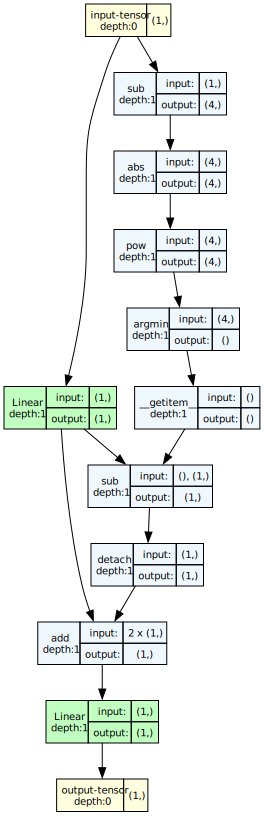

In [5]:
class Quantize(nn.Module):
    def __init__(self):
        super(Quantize, self).__init__()
        self.encoder = nn.Linear(1, 1)
        self.codebook = nn.Parameter(torch.tensor([-10., 0., 4., 3.]))
        self.decoder = nn.Linear(1, 1)

    def forward(self, x):
        z = self.encoder(x)
        closest = torch.argmin(torch.abs(x - self.codebook)**2, dim=-1)
        e_j = self.codebook[closest]
        e_j = z + (e_j - z).detach()
        d = self.decoder(e_j)
        return d

q = Quantize()
x = torch.ones(1).unsqueeze(0)
out = q(x)
out.backward()

#drawing the graph
model_graph = draw_graph(q, input_size=(1,), device="cpu")
model_graph.visual_graph

In [28]:
class VectorQuantizer(nn.Module):
    def __init__(self, codebook_size=1024, latent_dim=2):
        super(VectorQuantizer, self).__init__()
        
        self.embeddings = nn.Embedding(codebook_size, latent_dim)
        self.embeddings.weight.data.uniform_(-1/codebook_size, 1/codebook_size)
        
        self.latent_dim = latent_dim
        self.codebook_size = codebook_size
        
    def forward(self, x, efficient=True):
        
        batch_size = x.shape[0]
        
        #Embed : [B C L] -> Data: [B 1 L]
        if not efficient:
            emb = self.embeddings.weight.unsqueeze(0).repeat(batch_size, 1, 1)
            x = x.unsqueeze(1)
            dist = torch.sum((x - emb) ** 2, dim=-1)
        
        else :
            print(x)
            L2 = torch.sum(x ** 2, dim=-1, keepdim=True)
            C2 = torch.sum(self.embeddings.weight ** 2, dim=-1).unsqueeze(0)
            LC = x @ self.embeddings.weight.t()
            
            dist = L2 + C2 - 2 * LC
            print(f"L2: {L2.shape}, C2: {C2.shape}, LC: {LC.shape}, dist: {dist.shape}")
        
        print(f"dist: {dist}")
        closest = torch.argmin(dist, dim=-1)
        print(f"closest: {closest}\n")
        
        quantized_latent_idx = torch.zeros(batch_size, self.codebook_size, device=x.device)
        
        batch_idx = torch.arange(batch_size)
        quantized_latent_idx[batch_idx, closest] = 1
        
        quantized_latents = quantized_latent_idx @ self.embeddings.weight
        
        print(f"quantized_latent_idx: {quantized_latent_idx}")
        
        return quantized_latents
        
vq = VectorQuantizer(codebook_size=8, latent_dim=2)
rand = torch.randn(4, 2)
vq(rand)

tensor([[-0.8585, -0.3225],
        [-1.0736,  0.6848],
        [ 0.3500,  0.1106],
        [-0.0073,  0.2035]])
L2: torch.Size([4, 1]), C2: torch.Size([1, 8]), LC: torch.Size([4, 8]), dist: torch.Size([4, 8])
dist: tensor([[0.7020, 0.8624, 0.7763, 0.7271, 1.0350, 0.8634, 0.9391, 0.9048],
        [1.5590, 1.6155, 1.3927, 1.5591, 1.6513, 1.6894, 1.7317, 1.8972],
        [0.1991, 0.1270, 0.1767, 0.1858, 0.0793, 0.1258, 0.0990, 0.1225],
        [0.0687, 0.0357, 0.0224, 0.0603, 0.0173, 0.0500, 0.0430, 0.0922]],
       grad_fn=<SubBackward0>)
closest: tensor([0, 2, 4, 4])

quantized_latent_idx: tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.]])


tensor([[-0.0655, -0.0520],
        [-0.0681,  0.0669],
        [ 0.0687,  0.0962],
        [ 0.0687,  0.0962]], grad_fn=<MmBackward0>)

In [29]:
class LinearVectorQuantizedVAE(nn.Module):
    def __init__(self, codebook_size=1024, latent_dim=2):
        super(LinearVectorQuantizedVAE, self).__init__()
        
        #Encoder
        self.encoder = nn.Sequential(
            nn.Linear(32*32, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)   
        )
        
        #Vector Quantizer
        self.vq = VectorQuantizer(codebook_size, latent_dim)
        
        #Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 32*32),
            nn.Sigmoid(),
        )
        
    def forward_encoder(self, x):
        x = self.encoder(x)
        return x
    
    def forward_decoder(self, x):
        
        #get the quantized latent
        z_e, codebook_loss, commitment_loss = self.quantize(x)
        
        #decode the quantized latent
        x_reconstructed = self.decoder(z_e)
        
        return z_e, x_reconstructed, codebook_loss, commitment_loss
    
    def quantize(self, x):
        z_e = self.vq(x)
        
        #codebook loss
        codebook_loss = F.mse_loss(z_e, x.detach())
        
        #commitment loss
        commitment_loss = F.mse_loss(z_e.detach(), z_e)
        
        #total loss
        z_e = x + (z_e - x).detach()
        
        return z_e, codebook_loss, commitment_loss
    
    def forward(self, x):
        batch, channels, height, width = x.shape
        
        x = x.flatten(start_dim=1)
        
        z_e = self.forward_encoder(x)
        
        quantized_latents, decoded_latents, codebook_loss, commitment_loss = self.forward_decoder(z_e)
        
        decoded_latents = decoded_latents.reshape(batch, channels, height, width)
        
        return z_e, quantized_latents, decoded_latents, codebook_loss, commitment_loss
    
m = LinearVectorQuantizedVAE()
rand = torch.randn(4,1,32,32)
latents, quantized_latents, decoded, codebook_loss, commitment_loss = m(rand)

tensor([[ 0.0827, -0.0730],
        [ 0.1358, -0.1313],
        [ 0.1431, -0.1074],
        [ 0.1046, -0.0783]], grad_fn=<AddmmBackward0>)
L2: torch.Size([4, 1]), C2: torch.Size([1, 1024]), LC: torch.Size([4, 1024]), dist: torch.Size([4, 1024])
dist: tensor([[0.0122, 0.0123, 0.0120,  ..., 0.0123, 0.0122, 0.0121],
        [0.0357, 0.0359, 0.0354,  ..., 0.0360, 0.0357, 0.0356],
        [0.0320, 0.0322, 0.0317,  ..., 0.0323, 0.0320, 0.0320],
        [0.0171, 0.0172, 0.0169,  ..., 0.0173, 0.0171, 0.0171]],
       grad_fn=<SubBackward0>)
closest: tensor([357, 357, 357, 357])

quantized_latent_idx: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [31]:
class ConvolutionalVectorQuantizedVAE(nn.Module):
    def __init__(self, input_dim=1, latent_dim=32, codebook_size=512):
        super(ConvolutionalVectorQuantizedVAE, self).__init__()
        
        #latent dimension, in channels and codebook size
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.codebook_size = codebook_size
        
        #encoder (the layers can be changed to any number of layers)
        self.encoder = nn.Sequential(
            
            #1st conv layer
            nn.Conv2d(in_channels=self.input_dim, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            
            #2nd conv layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            #3rd conv layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(latent_dim),
            nn.ReLU()
        )
        
        #quantizer
        self.quantizer = VectorQuantizer(codebook_size, latent_dim)
        
        #decoder (the layers can be changed to any number of layers)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_dim, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            #2nd conv layer
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            
            #1st conv layer
            nn.ConvTranspose2d(in_channels=8, out_channels=self.input_dim, kernel_size=3, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def forward_encoder(self, x):
        batch_size, num_channels, height, width = x.shape
        conv_enc = self.encoder(x)
        return conv_enc

    def quantize(self, z):
        
        codes = self.quantizer(z)

        codebook_loss = torch.mean((codes - z.detach())**2)
        commitment_loss = torch.mean((codes.detach() - z)**2)

        codes = z + (codes - z).detach()
        

        return codes, codebook_loss, commitment_loss

    def forward_decoder(self, x):
        batch_size, channels, height, width = x.shape

        x = x.permute(0,2,3,1)
        x = torch.flatten(x, start_dim=0, end_dim=-2)

        codes, codebook_loss, commitment_loss = self.quantize(x)

        codes = codes.reshape(batch_size, height, width, channels)
        codes = codes.permute(0,3,1,2)

        conv_dec = self.decoder(codes)
        
        return codes, conv_dec, codebook_loss, commitment_loss
        
    def forward(self, x):
        batch_size, num_channels, height, width = x.shape
        latents = self.forward_encoder(x)
        quantized_latents, decoded, codebook_loss, commitment_loss = self.forward_decoder(latents)
        return latents, quantized_latents, decoded, codebook_loss, commitment_loss

rand = torch.randn(2, 1, 32, 32)
m = ConvolutionalVectorQuantizedVAE()
m(rand)

tensor([[0.3578, 0.0000, 0.0000,  ..., 1.9109, 0.2281, 1.8511],
        [0.0000, 0.0000, 1.3869,  ..., 1.2196, 0.0000, 0.0000],
        [0.5895, 0.5087, 0.0000,  ..., 0.6869, 0.8566, 0.7275],
        ...,
        [0.5462, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2325, 0.0000, 1.1470,  ..., 0.0000, 1.4008, 0.0000],
        [0.0000, 0.8495, 0.0000,  ..., 0.0000, 0.7196, 0.0000]],
       grad_fn=<UnsafeViewBackward0>)
L2: torch.Size([32, 1]), C2: torch.Size([1, 512]), LC: torch.Size([32, 512]), dist: torch.Size([32, 512])
dist: tensor([[16.4304, 16.4104, 16.4168,  ..., 16.4306, 16.4320, 16.4290],
        [13.8261, 13.8234, 13.8277,  ..., 13.8497, 13.8361, 13.8469],
        [ 8.4873,  8.4934,  8.4938,  ...,  8.4913,  8.5007,  8.4968],
        ...,
        [20.8698, 20.8652, 20.8743,  ..., 20.8749, 20.8864, 20.8800],
        [22.2160, 22.2136, 22.1974,  ..., 22.2185, 22.2191, 22.2215],
        [10.6840, 10.6805, 10.6724,  ..., 10.6841, 10.6818, 10.6850]],
       grad_fn=<Su

(tensor([[[[0.3578, 0.0000, 0.5895, 1.3557],
           [0.0000, 0.0000, 0.0000, 0.8277],
           [1.3614, 1.3766, 0.0000, 0.0552],
           [0.7328, 0.0000, 1.7344, 0.0000]],
 
          [[0.0000, 0.0000, 0.5087, 0.4649],
           [0.4029, 0.0000, 0.5305, 0.1004],
           [1.2815, 0.4429, 0.0000, 0.0000],
           [0.3491, 0.0000, 0.0000, 0.4756]],
 
          [[0.0000, 1.3869, 0.0000, 0.1466],
           [0.0000, 0.0000, 2.6313, 0.0000],
           [0.9922, 0.0000, 1.5210, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000]],
 
          ...,
 
          [[1.9109, 1.2196, 0.6869, 0.0000],
           [0.5496, 0.6550, 0.0000, 0.5419],
           [0.0000, 0.0000, 1.0827, 1.0500],
           [0.0000, 0.0000, 0.0000, 0.0000]],
 
          [[0.2281, 0.0000, 0.8566, 0.0000],
           [1.0854, 0.0000, 1.9768, 0.4101],
           [0.1687, 0.0000, 0.6643, 1.2829],
           [0.0000, 0.7868, 0.0556, 1.4298]],
 
          [[1.8511, 0.0000, 0.7275, 0.7614],
           [0.1504, 0.0